In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

SR = 16000
src_cute, _ = librosa.load('../srcs/bensound-cute.mp3', sr=SR, mono=True)

def print_info():
    print('%s/%s/%s' % (now.year, now.month, now.day))
    print('librosa version: {}'.format(librosa.__version__))
    print('Keras version: {}'.format(keras.__version__))
    if keras.backend._BACKEND == 'tensorflow':
        import tensorflow
        print('Keras backend: {}: {}'.format(keras.backend._backend, tensorflow.__version__))
    elif keras.backend._BACKEND == 'theano':
        import theano
        print('Keras backend: {}: {}'.format(keras.backend._backend, theano.__version__))
    print('Keras image data format: {}'.format(keras.backend.image_data_format()))
    print('Kapre version: {}'.format(kapre.__version__))
    print('\nSampling rate: {} Hz'.format(SR))

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    src, _ = librosa.load('../srcs/bensound-cute.mp3', sr=SR, mono=True)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    
    if logam:
        result = librosa.logamplitude(result)
    display.specshow(result, 
                     y_axis='linear', sr=SR)
    

Using TensorFlow backend.


In [2]:
print_info()

2017/6/19
librosa version: 0.5.0
Keras version: 2.0.4
Keras backend: tensorflow: 1.0.1
Keras image data format: channels_last
Kapre version: 0.0.4

Sampling rate: 16000 Hz


# Spectrogram

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
static_stft (Spectrogram) (None, 257, 188, 1)       263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s - loss: 1110030.7500


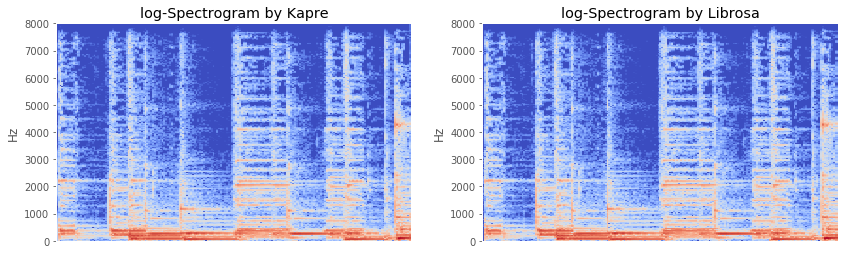

In [ ]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Spectrogram
import numpy as np
src = np.random.random((1, SR * 3))
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=src.shape, 
          return_decibel_spectrogram=False, power_spectrogram=2.0, 
          trainable_kernel=False, name='static_stft'))

check_model(model)
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('log-Spectrogram by Kapre')
visualise_model(model, logam=True)
plt.subplot(1, 2, 2)
display.specshow(librosa.logamplitude(np.abs(librosa.stft(src_cute[: SR * 3], 512, 256)) ** 2, ref_power=1.0), 
                         y_axis='linear', sr=SR)
plt.title('log-Spectrogram by Librosa')

# Spectrogram (trainable)

In [ ]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Spectrogram
import numpy as np

src = np.random.random((1, SR * 3))
model = Sequential()
model.add(Spectrogram(n_dft=1024, n_hop=256, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))

check_model(model)
visualise_model(model)

# Melspectrogram

In [ ]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram
import numpy as np

src = np.random.random((1, SR * 3))
model = Sequential()
model.add(Melspectrogram(sr=SR, n_mels=128, 
          n_dft=512, n_hop=256, input_shape=src.shape, 
          return_decibel_melgram=True,
          trainable_kernel=True, name='melgram'))

check_model(model)
visualise_model(model)

# AdditiveNoise

In [ ]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram
from kapre.augmentation import AdditiveNoise
import numpy as np

src = np.random.random((1, SR * 3))
model = Sequential()
model.add(Melspectrogram(sr=SR, n_mels=128, 
          n_dft=512, n_hop=256, input_shape=src.shape, 
          return_decibel_melgram=True,
          trainable_kernel=False, name='melgram'))
model.add(AdditiveNoise(power=10.))

check_model(model)
visualise_model(model)

**Warning**: additive noise is applied during training phase only.

# Filterbanks

In [ ]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Spectrogram
from kapre.filterbank import Filterbank

import numpy as np
src = np.random.random((1, SR * 3))
sr = SR
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=False, name='static_stft'))
model.add(Filterbank(n_fbs=50, trainable_fb=False, sr=SR, init='mel', fmin=0, fmax=sr//2, bins_per_octave=12,
                    name='mel_bank'))
check_model(model)
visualise_model(model)

In [ ]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Spectrogram
from kapre.filterbank import Filterbank

import numpy as np
src = np.random.random((1, SR * 3))
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=False, name='static_stft'))
model.add(Filterbank(n_fbs=60, trainable_fb=False, sr=SR, init='log', fmin=None, fmax=sr//2, bins_per_octave=12,
                    name='log_bank'))
check_model(model)
visualise_model(model)
